# Custom Architecture

In [1]:
model_name = 'custom-architecture-pre-processing-hist-eq-dark-and-canny-non-empty-3'

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from numba import cuda  # https://stackoverflow.com/a/52354865/6476994
import keras
import cv2
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from datetime import datetime
from readInImages import readInImages
from readInAnnotations import readInAnnotations

In [3]:
# allows all images to be displayed at once (else only displays the last call to plt.imshow())
# https://stackoverflow.com/a/41210974
def displayImage(image, caption = None, colour = None) -> None:
    plt.figure()
    if(colour != None):
        plt.imshow(image, cmap=colour)
    else:
        plt.imshow(image)
        
    if(caption != None):
        # display caption below picture (https://stackoverflow.com/a/51486361)
        plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)

In [4]:
# free up GPU if it didn't after the last run
cuda.select_device(0)
cuda.close()

## Read in dataset

* first argument is the `using_batch_generator` flag
* second argument is `do_preprocessing`, which will perform image manipulations for the purposes of enhancing training performance
* all other arguments are the datasets - e.g., a folder ('20160724_July') with additional folders ('BB01', 'BB02', ..., 'BBXY'), each containing a set of images)

In [5]:
%run readInDataset.py true true 20160724_July 20160829_August

args: ['readInDataset.py', 'true', 'true', '20160724_July', '20160829_August']
using_batch_generator? True
doing pre-processing? True
dataset_names: ['20160724_July', '20160829_August']
reading in images and labels for dataset: 20160724_July
all_folders_for_curr_dataset: ['BB01', 'BB02', 'BB03', 'BB04', 'BB05', 'BB06', 'BB07', 'BB08', 'BB09', 'BB10', 'BB11', 'BB12', 'BB13', 'BB14', 'BB15', 'BB16', 'BB17', 'BB18', 'BB19', 'BB20', 'BB21', 'BB22', 'BB23', 'BB24', 'BB25', 'BB26', 'BB27', 'BB28', 'BB29', 'BB30', 'BB31', 'BB32', 'BB33', 'BB34', 'BB35', 'BB36']
reading in labels for subset: BB01
returning labelList of length: 285
reading in images for subset: BB01
all_image_filenames length: 285
done current subset
reading in labels for subset: BB02
returning labelList of length: 45
reading in images for subset: BB02
all_image_filenames length: 45
done current subset
reading in labels for subset: BB03
returning labelList of length: 230
reading in images for subset: BB03
all_image_filenames le

In [6]:
class CustomGenerator(keras.utils.Sequence):    
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
    
    def __len__(self):
        return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)

    def __getitem__(self, idx):
        batch_x = self.images[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        
        return batch_x, np.array(batch_y)

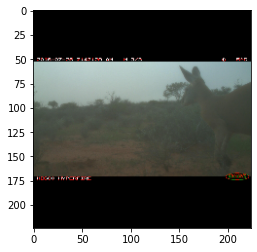

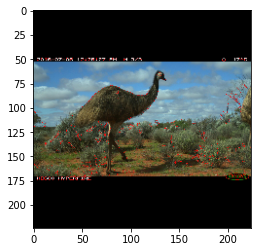

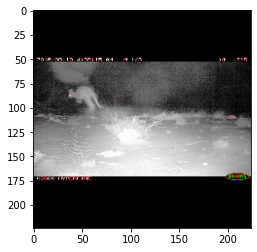

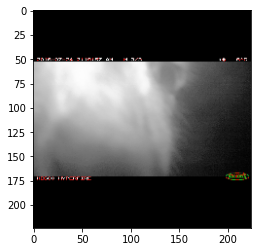

In [7]:
batch_size = 128

num_len_train = int(0.8 * len(training_images))

ttraining_images = training_images[:num_len_train]
ttraining_labels = training_labels[:num_len_train]

valid_images = training_images[num_len_train:]
valid_labels = training_labels[num_len_train:]

training_images = ttraining_images
training_labels = ttraining_labels

# show a few samples
displayImage(cv2.cvtColor(training_images[1], cv2.COLOR_BGR2RGB))
displayImage(cv2.cvtColor(training_images[10], cv2.COLOR_BGR2RGB))
displayImage(cv2.cvtColor(training_images[100], cv2.COLOR_BGR2RGB))
displayImage(cv2.cvtColor(training_images[1000], cv2.COLOR_BGR2RGB))

training_batch_generator = CustomGenerator(training_images, training_labels, batch_size)
validation_batch_generator = CustomGenerator(valid_images, valid_labels, batch_size)

## Construct the model architecture

In [8]:
model = tf.keras.models.Sequential([    
    #convolutional and pooling layers
    tf.keras.layers.Conv2D(96, (7, 7), strides=(2, 2), activation='relu',input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Flatten(),
    
    #fully-connected dense layers
    tf.keras.layers.Dense(254, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(5)])

2022-06-08 12:30:45.425506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 12:30:45.430896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 12:30:45.431071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 12:30:45.431393: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 109, 109, 96)      14208     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 54, 54, 96)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 279936)            0         
                                                                 
 dense (Dense)               (None, 254)               71103998  
                                                                 
 dense_1 (Dense)             (None, 64)                16320     
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                        

## Train the model

In [10]:
model.fit(training_batch_generator,
          validation_data=validation_batch_generator,
          epochs=90)

Epoch 1/90


/tmp/ipykernel_128164/4098404636.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)
2022-06-08 12:30:46.537530: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-06-08 12:30:46.921585: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to updat

89/89 [==============================] - 9s 87ms/step - loss: 48.7658 - accuracy: 0.8095 - top_k_categorical_accuracy: 0.9662 - val_loss: 0.5705 - val_accuracy: 0.8924 - val_top_k_categorical_accuracy: 0.9757
Epoch 2/90
89/89 [==============================] - 7s 81ms/step - loss: 0.4716 - accuracy: 0.9051 - top_k_categorical_accuracy: 0.9751 - val_loss: 0.3544 - val_accuracy: 0.9269 - val_top_k_categorical_accuracy: 0.9800
Epoch 3/90
89/89 [==============================] - 7s 81ms/step - loss: 0.3489 - accuracy: 0.9244 - top_k_categorical_accuracy: 0.9791 - val_loss: 0.2823 - val_accuracy: 0.9336 - val_top_k_categorical_accuracy: 0.9870
Epoch 4/90
89/89 [==============================] - 7s 82ms/step - loss: 0.2776 - accuracy: 0.9345 - top_k_categorical_accuracy: 0.9930 - val_loss: 0.2295 - val_accuracy: 0.9445 - val_top_k_categorical_accuracy: 0.9982
Epoch 5/90
89/89 [==============================] - 7s 84ms/step - loss: 0.2395 - accuracy: 0.9380 - top_k_categorical_accuracy: 0.996

## Use test set to assess trained model's performance

### Evaluate

In [11]:
print('test_images shape: {}'.format(test_images.shape))
print('test_labels shape: {}'.format(test_labels.shape))

results = model.evaluate(test_images,test_labels)
print('results: {}\n\n'.format(results))
print('loss: {}'.format(results[0]))
print('accuracy: {}'.format(results[1]))
print('top_k_categorical_accuracy: {}'.format(results[2]))

test_images shape: (3556, 224, 224, 3)
test_labels shape: (3556, 10)


2022-06-08 12:41:56.645834: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 535277568 exceeds 10% of free system memory.
2022-06-08 12:41:56.837547: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 535277568 exceeds 10% of free system memory.


112/112 [==============================] - 1s 9ms/step - loss: 0.0766 - accuracy: 0.9876 - top_k_categorical_accuracy: 0.9997
results: [0.07658262550830841, 0.9876265525817871, 0.9997187852859497]


loss: 0.07658262550830841
accuracy: 0.9876265525817871
top_k_categorical_accuracy: 0.9997187852859497


### Predict and print classification report

In [12]:
predictions = (model.predict(test_images) > 0.5).astype("int32")

2022-06-08 12:41:58.085540: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 535277568 exceeds 10% of free system memory.
2022-06-08 12:41:58.280941: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 535277568 exceeds 10% of free system memory.


112/112 [==============================] - 1s 7ms/step


In [13]:
print("test_classes: {}".format(test_classes))
print("train classes count: {}".format(counter_test))
# classification_report uses alphabetic ordering of the classes, so to match the encoded labels to the target_names, provide a sortest list of classes
# https://stackoverflow.com/a/48495303
sorted_test_classes = sorted(test_classes)
print(classification_report(test_labels, predictions, target_names=sorted_test_classes))

test_classes: ['Kangaroo', 'Empty photo', 'Emu', 'Human Presense/Deployment', 'Rabbit', 'Fox', 'Dog', 'Bird', 'Cat', 'Other']
train classes count: Counter({'Kangaroo': 2386, 'Empty photo': 620, 'Emu': 237, 'Human Presense/Deployment': 202, 'Fox': 60, 'Cat': 25, 'Rabbit': 12, 'Bird': 8, 'Other': 5, 'Dog': 1})
                           precision    recall  f1-score   support

                     Bird       0.89      1.00      0.94         8
                      Cat       0.96      0.92      0.94        25
                      Dog       0.00      0.00      0.00         1
              Empty photo       1.00      1.00      1.00       620
                      Emu       0.97      0.99      0.98       237
                      Fox       0.88      0.77      0.82        60
Human Presense/Deployment       0.95      0.98      0.96       202
                 Kangaroo       0.99      0.99      0.99      2386
                    Other       1.00      0.60      0.75         5
                   

/home/luke/miniconda3/envs/cv-project-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luke/miniconda3/envs/cv-project-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion matrix

In [14]:
matrix = confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1))
print(matrix)

[[   8    0    0    0    0    0    0    0    0    0]
 [   1   23    0    0    0    0    0    1    0    0]
 [   0    0    0    0    1    0    0    0    0    0]
 [   0    0    0  620    0    0    0    0    0    0]
 [   0    0    0    0  235    0    2    0    0    0]
 [   0    0    0    0    1   46    0   13    0    0]
 [   0    1    0    0    2    0  197    2    0    0]
 [   1    0    0    0    2    6    8 2368    0    1]
 [   1    0    0    0    0    0    0    1    3    0]
 [   0    0    0    0    1    0    0    0    0   11]]


### Accuracy

In [15]:
acc = accuracy_score(test_labels, predictions)
print(acc)

0.9873453318335208


## Save the model
* use the current date/time so we can keep incrementation progress of the model as we re-run it

In [16]:
if model_name == None:
    now = datetime.now()
    dt_string = now.strftime('%d-%m-%Y_%H:%M:%S')
    print("saving model as: 'custom-{}.h5'.'".format(dt_string))

    model.save('saved_models/custom-{}.h5'.format(dt_string))
else:
    existing_models = next(os.walk('saved_models/final'))[2]
    print('existing_models: {}'.format(existing_models))
    if model_name in existing_models:
        raise Exception('Tried to save a model that already exists. Aborting.')
    else:
        print("saving model as: '{}.h5'.'".format(model_name))
        model.save('saved_models/final/{}.h5'.format(model_name))

existing_models: ['InceptionV3-baseline-2.h5', 'InceptionV3-pre-processing-hist-eq-dark-and-canny-non-empty-2.h5', 'InceptionV3-pre-processing-hist-eq-dark-and-canny-non-empty-3.h5', 'custom-architecture-baseline-1.h5', 'InceptionV3-baseline-1.h5', 'InceptionV3-pre-processing-hist-eq-dark-and-canny-non-empty-1.h5', 'ZFNet-pre-processing-hist-eq-dark-and-canny-non-empty-1.h5', 'custom-architecture-pre-processing-hist-eq-dark-and-canny-non-empty-2.h5', 'ZFNet-pre-processing-hist-eq-dark-and-canny-non-empty-2.h5', 'ZFNet-pre-processing-hist-eq-dark-and-canny-non-empty-3.h5', 'custom-architecture-baseline-3.h5', 'ZFNet-baseline-3.h5', 'custom-architecture-baseline-2.h5', 'InceptionV3-baseline-3.h5', 'custom-architecture-pre-processing-hist-eq-dark-and-canny-non-empty-1.h5', 'ZFNet-baseline-2.h5', 'ZFNet-baseline-1.h5']
saving model as: 'custom-architecture-pre-processing-hist-eq-dark-and-canny-non-empty-3.h5'.'


2022-06-08 12:41:59.351178: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 284414976 exceeds 10% of free system memory.


## Free up the GPU's memory

In [17]:
cuda.select_device(0)
cuda.close()